In [1]:
# -*- coding: utf-8 -*-
"""
TotalSegmentator – Heart (mit Runtime-Messung)
- Volumenweise Segmentierung via totalsegmentator(task="total_mr")
- Speichert pro Slice PNG-Visualisierung & 1024x1024-Masken
- Runtime:
    * Wall-Clock über time_run_accumulate (akkumuliert über Neustarts)
    * CSV mit Stages:
        - segmenter_volume (slice_idx = -1): reine TS-Volumen-Segmentierung
        - post_slice (slice_idx = 0..Z-1): Visualisierung/Resize/Speichern
        - file_total (slice_idx = -3): Gesamtzeit der Datei
"""
import os
import json
import time
import csv
import gc
import logging

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from totalsegmentator.python_api import totalsegmentator

# ======================= Logging =======================
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# ======================= Pfade =========================
images_dir = "data/Heart/output_images"
visualization_dir = "data/Heart/segmentation_total_segmentator_atrium_left_results_with_run_time"
mask_dir = "data/Heart/segmentation_total_segmentator_atrium_left_results_with_run_time"
os.makedirs(visualization_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

# Zielgröße der Output-Masken (PNG)
target_size = (1024, 1024)  # (Breite, Höhe)

# =================== Runtime-Helper ====================
def _fmt(sec: float) -> str:
    h, r = divmod(sec, 3600)
    m, s = divmod(r, 60)
    return f"{int(h):02d}:{int(m):02d}:{s:05.2f}"

def _sum_seconds_from_csv(csv_path: str) -> float:
    if not os.path.exists(csv_path):
        return 0.0
    total = 0.0
    try:
        with open(csv_path, "r", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            if not reader.fieldnames or "seconds" not in reader.fieldnames:
                return 0.0
            for row in reader:
                try:
                    total += float(row["seconds"])
                except Exception:
                    continue
    except Exception as e:
        logging.warning(f"Konnte CSV nicht auswerten ({csv_path}): {e}")
    return total

def _load_runtime_state(state_path: str) -> dict:
    if os.path.exists(state_path):
        try:
            with open(state_path, "r", encoding="utf-8") as f:
                return json.load(f)
        except Exception as e:
            logging.warning(f"Konnte Runtime-State nicht lesen: {e}")
    return {"sessions": [], "total_elapsed_sec": 0.0}

def _save_runtime_state(state_path: str, state: dict):
    with open(state_path, "w", encoding="utf-8") as f:
        json.dump(state, f, indent=2)

def time_run_accumulate(func, state_path: str, seed_timing_csv: str, *args, **kwargs):
    """
    Misst Wall-Clock für den gesamten Run und akkumuliert in state_path.
    Loggt zusätzlich die Summe aller 'seconds' aus seed_timing_csv.
    """
    state = _load_runtime_state(state_path)
    start_perf = time.perf_counter()
    start_wall = time.time()
    logging.info("==== Starte Laufzeitmessung (akkumuliert) ====")
    try:
        return func(*args, **kwargs)
    finally:
        elapsed = time.perf_counter() - start_perf
        end_wall = time.time()

        state["sessions"].append({"start": start_wall, "end": end_wall, "elapsed_sec": elapsed})
        state["total_elapsed_sec"] = float(state.get("total_elapsed_sec", 0.0)) + float(elapsed)
        _save_runtime_state(state_path, state)

        msg1 = f"Aktueller Run: {_fmt(elapsed)} | Akkumuliert (Wall-Clock): {_fmt(state['total_elapsed_sec'])}"
        logging.info(msg1)

        total_csv_sec = _sum_seconds_from_csv(seed_timing_csv)
        msg2 = f"Akkumulierte Gesamtlaufzeit (aus CSV, alle Stages): {_fmt(total_csv_sec)}"
        logging.info(msg2)

        log_dir = os.path.dirname(seed_timing_csv) if seed_timing_csv else "."
        with open(os.path.join(log_dir, "runtime_log_totalseg_heart.txt"), "a", encoding="utf-8") as f:
            f.write(msg1 + "\n")
            f.write(msg2 + "\n")

# ================== Segmentierung + Save =================
def segment_and_save(images_dir: str, visualization_dir: str, mask_dir: str,
                     timing_csv: str, organ_label: str = "heart"):
    """
    Führt TotalSegmentator pro Volume aus und schreibt Timing als:
      - segmenter_volume: reine Dauer des totalsegmentator()-Calls
      - post_slice: je Slice Visualisierung/Resize/Save
      - file_total: Gesamtzeit pro Datei
    """
    image_files = sorted(os.listdir(images_dir))

    # Timing-CSV initialisieren
    if not os.path.exists(timing_csv):
        with open(timing_csv, "w", newline="", encoding="utf-8") as fcsv:
            csv.writer(fcsv).writerow(["file", "stage", "slice_idx", "seconds"])

    temp_output_base = "data/Heart/temp_segmentations_total_mr"
    os.makedirs(temp_output_base, exist_ok=True)

    with tqdm(total=len(image_files), desc="Processing files", unit="file") as pbar:
        for image_file in image_files:
            if not (image_file.endswith(".nii") or image_file.endswith(".nii.gz")):
                pbar.update(1)
                continue

            image_path = os.path.join(images_dir, image_file)
            base_name = os.path.splitext(os.path.splitext(image_file)[0])[0]  # z.B. la_018
            temp_output = os.path.join(temp_output_base, base_name)
            os.makedirs(temp_output, exist_ok=True)

            t_file = time.perf_counter()
            try:
                # ---------- 1) Volumen-Segmentierung timen ----------
                t_seg0 = time.perf_counter()
                totalsegmentator(
                    input=image_path,
                    output=temp_output,
                    task="total_mr"
                    # roi_subset=[organ_label]  # optional einschränken
                )
                seg_time = time.perf_counter() - t_seg0
                with open(timing_csv, "a", newline="", encoding="utf-8") as fcsv:
                    csv.writer(fcsv).writerow([image_file, "segmenter_volume", -1, f"{seg_time:.4f}"])
            except Exception as e:
                logging.error(f"Fehler bei der Segmentierung von {image_file}: {e}")
                pbar.update(1)
                continue

            # ---------- 2) Post-Processing & Visualisierung ----------
            try:
                nii_img = nib.load(image_path)
                image_data = nii_img.get_fdata(dtype=np.float32)

                seg_path = os.path.join(temp_output, f"{organ_label}.nii.gz")
                if not os.path.exists(seg_path):
                    logging.warning(f"Keine Segmentierung für {image_file} gefunden (erwartet: {seg_path}).")
                    pbar.update(1)
                    continue

                nii_seg = nib.load(seg_path)
                seg_data = nii_seg.get_fdata(dtype=np.float32)
                total_slices = image_data.shape[2]

                for slice_idx in range(total_slices):
                    t_slice0 = time.perf_counter()

                    img_slice = image_data[:, :, slice_idx]
                    seg_slice = seg_data[:, :, slice_idx]

                    # Binäre Maske
                    seg_mask = (seg_slice > 0).astype(np.uint8)

                    # Visualisierung
                    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                    ax[0].imshow(img_slice, cmap="gray")
                    ax[0].set_title(f"Original Slice {slice_idx}")
                    ax[0].axis('off')
                    ax[1].imshow(img_slice, cmap="gray")
                    ax[1].imshow(seg_mask, cmap="jet", alpha=0.5)
                    ax[1].set_title(f"Segmentierung Slice {slice_idx}")
                    ax[1].axis('off')

                    vis_save_path = os.path.join(visualization_dir, f"{base_name}_slice_{slice_idx}_visualization.png")
                    plt.savefig(vis_save_path, bbox_inches="tight")
                    plt.close(fig)

                    # Maske auf 1024 x 1024 skalieren (NEAREST, damit Labels erhalten bleiben)
                    seg_mask_resized = cv2.resize(seg_mask, target_size, interpolation=cv2.INTER_NEAREST)

                    # Maske speichern
                    mask_save_path = os.path.join(mask_dir, f"{base_name}_slice_{slice_idx}_segmentation.png")
                    cv2.imwrite(mask_save_path, seg_mask_resized * 255)

                    # Slice-Postzeit loggen
                    post_time = time.perf_counter() - t_slice0
                    with open(timing_csv, "a", newline="", encoding="utf-8") as fcsv:
                        csv.writer(fcsv).writerow([image_file, "post_slice", slice_idx, f"{post_time:.4f}"])

                    gc.collect()

            except Exception as e:
                logging.error(f"Fehler im Postprocessing von {image_file}: {e}")

            # ---------- 3) Datei-Gesamtzeit ----------
            file_total = time.perf_counter() - t_file
            with open(timing_csv, "a", newline="", encoding="utf-8") as fcsv:
                csv.writer(fcsv).writerow([image_file, "file_total", -3, f"{file_total:.4f}"])

            pbar.update(1)

            # Optional: Temp-Ordner löschen
            # import shutil; shutil.rmtree(temp_output, ignore_errors=True)

# ======================== Run ===========================
if __name__ == "__main__":
    output_dir_for_timing = mask_dir  # CSV neben den Ergebnissen
    os.makedirs(output_dir_for_timing, exist_ok=True)

    timing_csv    = os.path.join(output_dir_for_timing, "timing_totalseg_heart.csv")
    runtime_state = os.path.join(output_dir_for_timing, "runtime_state_totalseg_heart.json")

    # Wall-Clock + CSV-basierte Summe (alle Stages)
    time_run_accumulate(
        segment_and_save,
        runtime_state,
        seed_timing_csv=timing_csv,
        images_dir=images_dir,
        visualization_dir=visualization_dir,
        mask_dir=mask_dir,
        timing_csv=timing_csv,
        organ_label="heart"  # z.B. "heart_atrium_left", "heart_ventricle_left", ...
    )

    # Optional: Gesamtsumme aus CSV explizit loggen
    total_csv_sec = _sum_seconds_from_csv(timing_csv)
    logging.info(f"[FINAL] Gesamtlaufzeit (Summe CSV über alle Stages): {_fmt(total_csv_sec)}")


2025-09-15 12:36:22,811 - INFO - ==== Starte Laufzeitmessung (akkumuliert) ====
Processing files:   0%|                                                                       | 0/20 [00:00<?, ?file/s]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.91s
Predicting part 1 of 2 ...


F:\Rawan_Masterarbeit\venv_totalseg\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:52<00:00, 14.09s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:04<00:00, 15.62s/it]


  Predicted in 314.24s
Resampling...
Saving segmentations...
  Saved in 36.13s


Processing files:   5%|███                                                         | 1/20 [07:03<2:14:02, 423.29s/file]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.35s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:07<00:00, 15.95s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:45<00:00, 13.17s/it]


  Predicted in 290.85s
Resampling...
Saving segmentations...
  Saved in 33.28s


Processing files:  10%|██████                                                      | 2/20 [13:14<1:57:46, 392.57s/file]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.10s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:43<00:00, 12.96s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:49<00:00, 13.70s/it]


  Predicted in 251.97s
Resampling...
Saving segmentations...
  Saved in 31.32s


Processing files:  15%|█████████                                                   | 3/20 [18:43<1:43:04, 363.81s/file]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.14s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:42<00:00, 12.85s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:42<00:00, 12.85s/it]


  Predicted in 245.87s
Resampling...
Saving segmentations...
  Saved in 28.03s


Processing files:  20%|████████████                                                | 4/20 [24:24<1:34:32, 354.55s/file]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.40s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:49<00:00, 13.67s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:53<00:00, 14.15s/it]


  Predicted in 265.06s
Resampling...
Saving segmentations...
  Saved in 37.27s


Processing files:  25%|███████████████                                             | 5/20 [30:22<1:28:56, 355.76s/file]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.72s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:15<00:00, 16.98s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:41<00:00, 12.66s/it]


  Predicted in 291.85s
Resampling...
Saving segmentations...
  Saved in 31.93s


Processing files:  30%|██████████████████                                          | 6/20 [36:25<1:23:34, 358.19s/file]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.47s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:43<00:00, 12.96s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:43<00:00, 12.97s/it]


  Predicted in 246.19s
Resampling...
Saving segmentations...
  Saved in 33.00s


Processing files:  35%|█████████████████████                                       | 7/20 [41:48<1:15:09, 346.89s/file]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.36s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:46<00:00, 13.27s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:41<00:00, 12.70s/it]


  Predicted in 260.75s
Resampling...
Saving segmentations...
  Saved in 36.08s


Processing files:  40%|████████████████████████                                    | 8/20 [47:29<1:09:00, 345.02s/file]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.78s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:45<00:00, 13.15s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:44<00:00, 13.12s/it]


  Predicted in 248.42s
Resampling...
Saving segmentations...
  Saved in 33.94s


Processing files:  45%|███████████████████████████                                 | 9/20 [52:52<1:01:56, 337.91s/file]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.08s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:59<00:00, 14.94s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:46<00:00, 13.34s/it]


  Predicted in 280.64s
Resampling...
Saving segmentations...
  Saved in 34.32s


Processing files:  50%|██████████████████████████████▌                              | 10/20 [58:50<57:21, 344.12s/file]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.13s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:48<00:00, 13.54s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:45<00:00, 13.23s/it]


  Predicted in 255.32s
Resampling...
Saving segmentations...
  Saved in 32.48s


Processing files:  55%|████████████████████████████████▍                          | 11/20 [1:04:20<50:59, 339.94s/file]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.08s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:50<00:00, 13.82s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:43<00:00, 12.91s/it]


  Predicted in 251.15s
Resampling...
Saving segmentations...
  Saved in 27.75s


Processing files:  60%|███████████████████████████████████▍                       | 12/20 [1:09:46<44:46, 335.78s/file]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.97s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:44<00:00, 13.09s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:52<00:00, 14.08s/it]


  Predicted in 262.03s
Resampling...
Saving segmentations...
  Saved in 34.46s


Processing files:  65%|██████████████████████████████████████▎                    | 13/20 [1:15:39<39:46, 340.92s/file]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.95s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:01<00:00, 15.23s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:41<00:00, 20.14s/it]


  Predicted in 335.81s
Resampling...
Saving segmentations...
  Saved in 39.54s


Processing files:  70%|█████████████████████████████████████████▎                 | 14/20 [1:22:49<36:47, 367.94s/file]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.84s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:51<00:00, 13.94s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:32<00:00, 19.00s/it]


  Predicted in 342.08s
Resampling...
Saving segmentations...
  Saved in 44.31s


Processing files:  75%|████████████████████████████████████████████▎              | 15/20 [1:30:04<32:19, 387.88s/file]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.57s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:46<00:00, 13.33s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:49<00:00, 13.66s/it]


  Predicted in 255.99s
Resampling...
Saving segmentations...
  Saved in 32.11s


Processing files:  80%|███████████████████████████████████████████████▏           | 16/20 [1:35:27<24:34, 368.51s/file]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.24s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:45<00:00, 13.16s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:43<00:00, 12.96s/it]


  Predicted in 247.98s
Resampling...
Saving segmentations...
  Saved in 32.30s


Processing files:  85%|██████████████████████████████████████████████████▏        | 17/20 [1:40:52<17:46, 355.52s/file]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.11s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:45<00:00, 13.19s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:45<00:00, 13.19s/it]


  Predicted in 250.03s
Resampling...
Saving segmentations...
  Saved in 31.26s


Processing files:  90%|█████████████████████████████████████████████████████      | 18/20 [1:46:20<11:34, 347.21s/file]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.70s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:44<00:00, 13.07s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:42<00:00, 12.86s/it]


  Predicted in 244.53s
Resampling...
Saving segmentations...
  Saved in 27.06s


Processing files:  95%|████████████████████████████████████████████████████████   | 19/20 [1:51:30<05:36, 336.07s/file]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.89s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:49<00:00, 13.70s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:00<00:00, 15.05s/it]


  Predicted in 268.84s
Resampling...
Saving segmentations...
  Saved in 34.42s


Processing files: 100%|███████████████████████████████████████████████████████████| 20/20 [1:57:18<00:00, 351.93s/file]
2025-09-15 14:33:41,399 - INFO - Aktueller Run: 01:57:18.58 | Akkumuliert (Wall-Clock): 01:57:18.58
2025-09-15 14:33:41,593 - INFO - Akkumulierte Gesamtlaufzeit (aus CSV, alle Stages): 03:57:16.19
2025-09-15 14:33:41,607 - INFO - [FINAL] Gesamtlaufzeit (Summe CSV über alle Stages): 03:57:16.19


In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import gc
import logging
from tqdm import tqdm
from totalsegmentator.python_api import totalsegmentator

# Logging konfigurieren
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Ordnerpfade
images_dir = "data/Heart/output_images"
visualization_dir = "data/Heart/segmentation_total_segmentator_atrium_left_results"
mask_dir = "data/Heart/segmentation_total_segmentator_atrium_left_results"
os.makedirs(visualization_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

# Zielgröße der Ground-Truth-Bilder
target_size = (1024, 1024)  # (Breite, Höhe)

# Segmentierung + Maske + Visualisierung
def segment_and_save(images_dir, visualization_dir, mask_dir, organ_label="heart"):
    image_files = sorted(os.listdir(images_dir))

    temp_output_base = "data/Heart/temp_segmentations_total_mr"
    os.makedirs(temp_output_base, exist_ok=True)

    for image_file in tqdm(image_files, desc="Processing files"):
        image_path = os.path.join(images_dir, image_file)

        if not (image_file.endswith(".nii") or image_file.endswith(".nii.gz")):
            continue

        # Ordner für diese Datei im temp_output anlegen
        base_name = os.path.splitext(os.path.splitext(image_file)[0])[0]  # z.B. la_018
        temp_output = os.path.join(temp_output_base, base_name)
        if not os.path.exists(temp_output):
            os.makedirs(temp_output)

        try:
            # Segmentierung starten mit speziellem Task
            totalsegmentator(
                input=image_path,
                output=temp_output,
                task="total_mr"
                # roi_subset=[organ_label]
            )
        except Exception as e:
            logging.error(f"Fehler bei der Segmentierung von {image_file}: {e}")
            continue

        # Bilddaten laden
        nii_img = nib.load(image_path)
        image_data = nii_img.get_fdata()

        # Pfad zur Segmentierung im Unterordner
        seg_path = os.path.join(temp_output, f"{organ_label}.nii.gz")
        if not os.path.exists(seg_path):
            logging.warning(f"Keine Segmentierung für {image_file} gefunden.")
            continue

        nii_seg = nib.load(seg_path)
        seg_data = nii_seg.get_fdata()

        total_slices = image_data.shape[2]

        for slice_idx in range(total_slices):
            img_slice = image_data[:, :, slice_idx]
            seg_slice = seg_data[:, :, slice_idx]

            # Binäre Maske
            seg_mask = (seg_slice > 0).astype(np.uint8)

            # Visualisierung
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            ax[0].imshow(img_slice, cmap="gray")
            ax[0].set_title(f"Original Slice {slice_idx}")
            ax[0].axis('off')
            ax[1].imshow(img_slice, cmap="gray")
            ax[1].imshow(seg_mask, cmap="jet", alpha=0.5)
            ax[1].set_title(f"Segmentierung Slice {slice_idx}")
            ax[1].axis('off')

            vis_save_path = os.path.join(visualization_dir, f"{base_name}_slice_{slice_idx}_visualization.png")
            plt.savefig(vis_save_path, bbox_inches="tight")
            plt.close(fig)

            # Maske auf 1024 x 1024 skalieren
            seg_mask_resized = cv2.resize(seg_mask, target_size, interpolation=cv2.INTER_NEAREST)

            # Maske speichern
            mask_save_path = os.path.join(mask_dir, f"{base_name}_slice_{slice_idx}_segmentation.png")
            cv2.imwrite(mask_save_path, seg_mask_resized * 255)

            gc.collect()

        # Optional: Temp Ordner komplett löschen
        # Achtung: Wenn du die Ergebnisse behalten willst, bitte nicht löschen!
        # import shutil
        # shutil.rmtree(temp_output)

# Ausführen
segment_and_save(images_dir, visualization_dir, mask_dir)


Processing files:   0%|                                                                         | 0/20 [00:00<?, ?it/s]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.97s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:45<00:00, 13.23s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:51<00:00, 13.88s/it]


  Predicted in 264.76s
Resampling...
Saving segmentations...
  Saved in 33.71s


Processing files:   5%|███                                                           | 1/20 [06:04<1:55:16, 364.05s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.87s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:56<00:00, 14.55s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:49<00:00, 13.74s/it]


  Predicted in 270.61s
Resampling...
Saving segmentations...
  Saved in 34.19s


Processing files:  10%|██████▏                                                       | 2/20 [12:04<1:48:32, 361.81s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.48s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:16<00:00, 17.06s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:40<00:00, 12.54s/it]


  Predicted in 284.43s
Resampling...
Saving segmentations...
  Saved in 29.96s


Processing files:  15%|█████████▎                                                    | 3/20 [18:10<1:43:01, 363.62s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.52s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:46<00:00, 13.37s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:34<00:00, 19.37s/it]


  Predicted in 309.33s
Resampling...
Saving segmentations...
  Saved in 32.90s


Processing files:  20%|████████████▍                                                 | 4/20 [24:46<1:40:28, 376.76s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.82s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:44<00:00, 13.07s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:42<00:00, 12.75s/it]


  Predicted in 249.32s
Resampling...
Saving segmentations...
  Saved in 53.44s


Processing files:  25%|███████████████▌                                              | 5/20 [30:49<1:32:55, 371.69s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.88s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:58<00:00, 14.75s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:47<00:00, 13.42s/it]


  Predicted in 272.89s
Resampling...
Saving segmentations...
  Saved in 31.12s


Processing files:  30%|██████████████████▌                                           | 6/20 [36:35<1:24:40, 362.92s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.36s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:01<00:00, 15.15s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:41<00:00, 12.74s/it]


  Predicted in 270.72s
Resampling...
Saving segmentations...
  Saved in 30.46s


Processing files:  35%|█████████████████████▋                                        | 7/20 [42:24<1:17:40, 358.50s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.23s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:44<00:00, 13.09s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:46<00:00, 13.28s/it]


  Predicted in 254.51s
Resampling...
Saving segmentations...
  Saved in 34.42s


Processing files:  40%|████████████████████████▊                                     | 8/20 [48:05<1:10:35, 352.93s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.06s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:43<00:00, 12.95s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:43<00:00, 12.99s/it]


  Predicted in 248.96s
Resampling...
Saving segmentations...
  Saved in 30.30s


Processing files:  45%|███████████████████████████▉                                  | 9/20 [53:33<1:03:14, 344.96s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.91s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:42<00:00, 12.87s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:49<00:00, 13.63s/it]


  Predicted in 256.01s
Resampling...
Saving segmentations...
  Saved in 33.48s


Processing files:  50%|███████████████████████████████▌                               | 10/20 [59:05<56:50, 341.03s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.13s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:49<00:00, 13.74s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:42<00:00, 12.83s/it]


  Predicted in 256.92s
Resampling...
Saving segmentations...
  Saved in 30.39s


Processing files:  55%|█████████████████████████████████▌                           | 11/20 [1:04:37<50:45, 338.38s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.38s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:44<00:00, 13.09s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:41<00:00, 12.74s/it]


  Predicted in 248.94s
Resampling...
Saving segmentations...
  Saved in 30.35s


Processing files:  60%|████████████████████████████████████▌                        | 12/20 [1:10:06<44:42, 335.30s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.35s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:49<00:00, 13.73s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:41<00:00, 12.68s/it]


  Predicted in 251.56s
Resampling...
Saving segmentations...
  Saved in 30.99s


Processing files:  65%|███████████████████████████████████████▋                     | 13/20 [1:15:36<38:55, 333.69s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.29s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:43<00:00, 12.90s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:43<00:00, 12.92s/it]


  Predicted in 249.94s
Resampling...
Saving segmentations...
  Saved in 41.55s


Processing files:  70%|██████████████████████████████████████████▋                  | 14/20 [1:21:22<33:45, 337.50s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.82s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:46<00:00, 13.33s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:42<00:00, 12.79s/it]


  Predicted in 253.93s
Resampling...
Saving segmentations...
  Saved in 33.64s


Processing files:  75%|█████████████████████████████████████████████▊               | 15/20 [1:26:54<27:58, 335.70s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.79s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:49<00:00, 13.71s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:52<00:00, 14.11s/it]


  Predicted in 265.69s
Resampling...
Saving segmentations...
  Saved in 41.69s


Processing files:  80%|████████████████████████████████████████████████▊            | 16/20 [1:32:41<22:37, 339.37s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.31s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:43<00:00, 12.96s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:50<00:00, 13.80s/it]


  Predicted in 257.37s
Resampling...
Saving segmentations...
  Saved in 31.86s


Processing files:  85%|███████████████████████████████████████████████████▊         | 17/20 [1:38:30<17:06, 342.17s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.43s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:49<00:00, 13.65s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:44<00:00, 13.05s/it]


  Predicted in 258.98s
Resampling...
Saving segmentations...
  Saved in 35.25s


Processing files:  90%|██████████████████████████████████████████████████████▉      | 18/20 [1:44:16<11:26, 343.42s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.08s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:45<00:00, 13.21s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:42<00:00, 12.86s/it]


  Predicted in 251.04s
Resampling...
Saving segmentations...
  Saved in 32.21s


Processing files:  95%|█████████████████████████████████████████████████████████▉   | 19/20 [1:49:41<05:37, 337.77s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.07s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:54<00:00, 14.28s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:46<00:00, 13.35s/it]


  Predicted in 263.55s
Resampling...
Saving segmentations...
  Saved in 30.83s


Processing files: 100%|█████████████████████████████████████████████████████████████| 20/20 [1:55:22<00:00, 346.14s/it]


In [4]:
import os
import numpy as np
import cv2
import logging
import csv
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

# Logging konfigurieren
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Ordner mit den Masken
mask_png_folder = os.path.join("data", "Heart", "output_masks_updated")
segmentation_results_folder = os.path.join("data", "Heart", "segmentation_total_segmentator_atrium_left_results")

# Funktion zur Berechnung des Dice Scores
def dice_score(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    if np.sum(mask1) + np.sum(mask2) == 0:
        return 1.0  # Sonderfall: Beide Masken sind komplett leer
    dice = (2. * intersection) / (np.sum(mask1) + np.sum(mask2))
    return dice

# Funktion zur Verarbeitung einer einzelnen Datei
def process_single_file(mask_filename):
    try:
        # Beispiel: la_003_slice_01_segmentation.png
        if "_slice_" not in mask_filename:
            return None

        base_name = mask_filename.split("_slice_")[0]  # z. B. la_003
        slice_number = mask_filename.split("_slice_")[-1].split("_")[0]  # z. B. "01"
        slice_number_int = int(slice_number)
        segmentation_filename = f"{base_name}_slice_{slice_number_int}_segmentation.png"

        mask_png_path = os.path.join(mask_png_folder, mask_filename)
        segmentation_path = os.path.join(segmentation_results_folder, segmentation_filename)

        if not os.path.exists(segmentation_path):
            logging.warning(f"Segmentationsdatei für {mask_filename} nicht gefunden!")
            return None

        # Masken laden
        mask_png = cv2.imread(mask_png_path, cv2.IMREAD_GRAYSCALE)
        segmentation = cv2.imread(segmentation_path, cv2.IMREAD_GRAYSCALE)

        if mask_png is None or segmentation is None:
            logging.error(f"Fehler beim Laden von: {mask_filename}")
            return None

        # Sicherstellen, dass beide Masken binär sind (0 und 1)
        mask_png = (mask_png > 0).astype(np.uint8)
        segmentation = (segmentation > 0).astype(np.uint8)

        # Dice Score berechnen
        dice = dice_score(mask_png, segmentation)
        logging.info(f"{mask_filename}: Dice Score = {dice:.4f}")
        return mask_filename, dice

    except Exception as e:
        logging.error(f"Fehler beim Verarbeiten von {mask_filename}: {e}")
        return None

# Parallelisierte Verarbeitung aller PNGs im Maskenordner
dice_scores = []
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_single_file, fname) for fname in os.listdir(mask_png_folder) if fname.endswith(".png")]
    dice_scores = [future.result() for future in futures if future.result() is not None]

# Ergebnisse speichern und analysieren
if dice_scores:
    # Ergebnisse in CSV speichern
    output_csv_path = os.path.join("data", "Heart", "dice_scores_totalsegmentator.csv")
    with open(output_csv_path, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Maskenname", "Dice Score"])
        writer.writerows(dice_scores)

    # Durchschnitt berechnen
    dice_values = [score for _, score in dice_scores]
    avg_dice = np.mean(dice_values)
    logging.info(f"\nDurchschnittlicher Dice Score: {avg_dice:.4f}")

    # Histogramm erstellen
    plt.figure(figsize=(8, 6))
    plt.hist(dice_values, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Verteilung der Dice Scores')
    plt.xlabel('Dice Score')
    plt.ylabel('Häufigkeit')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Durchschnitt im Histogramm markieren
    plt.axvline(avg_dice, color='red', linestyle='dashed', linewidth=1.5, label=f'Durchschnitt: {avg_dice:.4f}')
    plt.legend()

    # Plot speichern und anzeigen
    output_plot_path = os.path.join("data", "Heart", "dice_score_histogram_totalsegmentator.png")
    plt.savefig(output_plot_path)
    plt.show()
else:
    logging.info("Keine Dice Scores berechnet!")


2025-06-10 12:58:50,714 - INFO - la_003_slice_02_segmentation.png: Dice Score = 0.0000
2025-06-10 12:58:50,730 - INFO - la_003_slice_07_segmentation.png: Dice Score = 0.0000
2025-06-10 12:58:50,733 - INFO - la_003_slice_04_segmentation.png: Dice Score = 0.0000
2025-06-10 12:58:50,770 - INFO - la_003_slice_03_segmentation.png: Dice Score = 0.0000
2025-06-10 12:58:50,765 - INFO - la_003_slice_06_segmentation.png: Dice Score = 0.0000
2025-06-10 12:58:50,792 - INFO - la_003_slice_08_segmentation.png: Dice Score = 0.0000
2025-06-10 12:58:50,796 - INFO - la_003_slice_05_segmentation.png: Dice Score = 0.0000
2025-06-10 12:58:50,840 - INFO - la_003_slice_09_segmentation.png: Dice Score = 0.0000
2025-06-10 12:58:50,859 - INFO - la_003_slice_01_segmentation.png: Dice Score = 0.0000
2025-06-10 12:58:50,861 - INFO - la_003_slice_11_segmentation.png: Dice Score = 0.0000
2025-06-10 12:58:50,863 - INFO - la_003_slice_10_segmentation.png: Dice Score = 0.0000
2025-06-10 12:58:50,896 - INFO - la_003_sli

In [1]:
"""
import os
import matplotlib.pyplot as plt
import csv
import logging

# Konfiguration
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
csv_path = "data/upper_airways/combined_segmentations/dice_scores_2_combined_segmentations.csv"
output_plot = "data/upper_airways/dice_histogram_2_combined.png"
"""
# Dice-Werte laden
dice_values = []
try:
    with open(csv_path, newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            try:
                dice_values.append(float(row["Dice Score"]))
            except ValueError:
                logging.warning(f"Ungültiger Wert: {row['Dice Score']}")
except FileNotFoundError:
    logging.error(f"CSV-Datei nicht gefunden: {csv_path}")
    dice_values = []

# Histogramm erzeugen
if dice_values:
    avg_dice = sum(dice_values) / len(dice_values)

    plt.figure(figsize=(8, 6))
    plt.hist(dice_values, bins=20, color="blue", alpha=0.7, edgecolor="black")
    plt.axvline(avg_dice, color="red", linestyle="--", label=f"Durchschnitt: {avg_dice:.4f}")
    plt.title("Dice Score Verteilung")
    plt.xlabel("Dice Score")
    plt.ylabel("Häufigkeit")
    plt.legend()
    plt.grid(True)

    plt.savefig(output_plot)
    plt.show()
    logging.info(f"Histogramm gespeichert: {output_plot}")
else:
    logging.info("Keine Dice-Werte zum Plotten gefunden.")


NameError: name 'csv_path' is not defined

### Resampling step

In [1]:
import os
import SimpleITK as sitk
import logging

# Logging konfigurieren
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Ordnerpfade
images_dir = "data/Heart/output_images"  # Dein Ordner mit den MRI-Bildern
resampled_dir = "data/Heart/resampled_images"  # Ordner, in dem die resampelten Bilder gespeichert werden
os.makedirs(resampled_dir, exist_ok=True)

# Ziel Pixel Spacing (z.B. 1 mm in alle Dimensionen)
desired_spacing = (1.0, 1.0, 1.0)  # (x, y, z) in mm

def resample_image(image_path, desired_spacing):
    """
    Funktion zum Resampeln eines NIfTI-Bildes auf ein gewünschtes Pixel Spacing.
    """
    # Bild laden
    img = sitk.ReadImage(image_path)
    current_spacing = img.GetSpacing()

    # Wenn das aktuelle Pixel Spacing nicht dem gewünschten entspricht, wird ein Resampling durchgeführt
    if current_spacing != desired_spacing:
        resampler = sitk.ResampleImageFilter()
        # Berechne die neue Größe des Bildes basierend auf dem gewünschten Spacing
        new_size = [int(sz * spc / ds) for sz, spc, ds in zip(img.GetSize(), current_spacing, desired_spacing)]
        resampler.SetSize(new_size)
        resampler.SetOutputSpacing(desired_spacing)
        resampler.SetOutputOrigin(img.GetOrigin())
        resampler.SetOutputDirection(img.GetDirection())
        
        # Resample das Bild
        resampled_img = resampler.Execute(img)
        return resampled_img
    return img  # Rückgabe des Bildes, falls kein Resampling notwendig ist

def resample_images_in_directory(images_dir, resampled_dir, desired_spacing):
    """
    Diese Funktion durchsucht den angegebenen Ordner nach NIfTI-Bildern, resampelt sie
    und speichert die resampelten Bilder in einem neuen Ordner.
    """
    image_files = sorted(os.listdir(images_dir))

    for image_file in image_files:
        image_path = os.path.join(images_dir, image_file)

        # Nur NIfTI-Dateien (.nii oder .nii.gz) verarbeiten
        if image_file.endswith(".nii") or image_file.endswith(".nii.gz"):
            try:
                # Bild resampeln
                resampled_img = resample_image(image_path, desired_spacing)

                # Pfad für das resampelte Bild erstellen
                resampled_img_path = os.path.join(resampled_dir, f"resampled_{image_file}")
                
                # Resampeltes Bild speichern
                sitk.WriteImage(resampled_img, resampled_img_path)
                logging.info(f"Resampled Bild gespeichert: {resampled_img_path}")

            except Exception as e:
                logging.error(f"Fehler bei der Verarbeitung von {image_file}: {e}")

# Resample die Bilder
resample_images_in_directory(images_dir, resampled_dir, desired_spacing)


2025-06-12 10:52:56,605 - INFO - Resampled Bild gespeichert: data/Heart/resampled_images\resampled_la_003.nii.gz
2025-06-12 10:53:05,196 - INFO - Resampled Bild gespeichert: data/Heart/resampled_images\resampled_la_004.nii.gz
2025-06-12 10:53:38,410 - INFO - Resampled Bild gespeichert: data/Heart/resampled_images\resampled_la_005.nii.gz
2025-06-12 10:53:56,811 - INFO - Resampled Bild gespeichert: data/Heart/resampled_images\resampled_la_007.nii.gz
2025-06-12 10:54:05,583 - INFO - Resampled Bild gespeichert: data/Heart/resampled_images\resampled_la_009.nii.gz
2025-06-12 10:54:12,030 - INFO - Resampled Bild gespeichert: data/Heart/resampled_images\resampled_la_010.nii.gz
2025-06-12 10:54:19,553 - INFO - Resampled Bild gespeichert: data/Heart/resampled_images\resampled_la_011.nii.gz
2025-06-12 10:54:26,774 - INFO - Resampled Bild gespeichert: data/Heart/resampled_images\resampled_la_014.nii.gz
2025-06-12 10:54:32,243 - INFO - Resampled Bild gespeichert: data/Heart/resampled_images\resampl

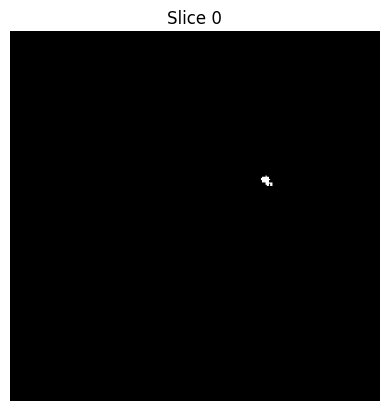

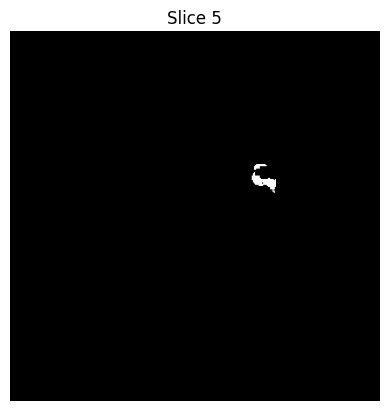

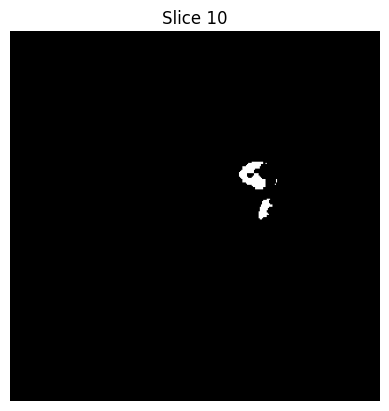

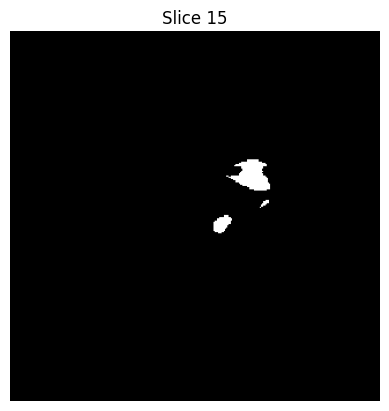

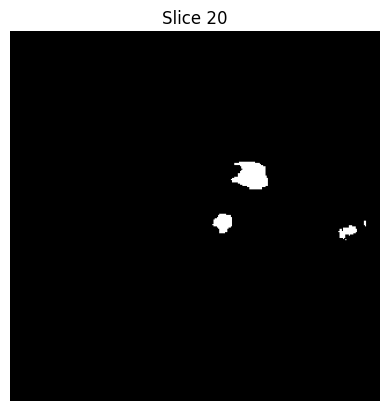

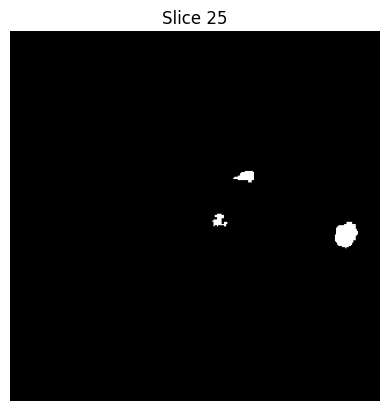

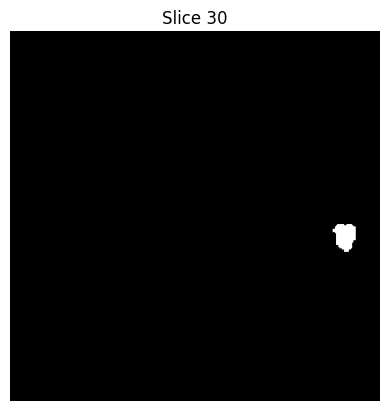

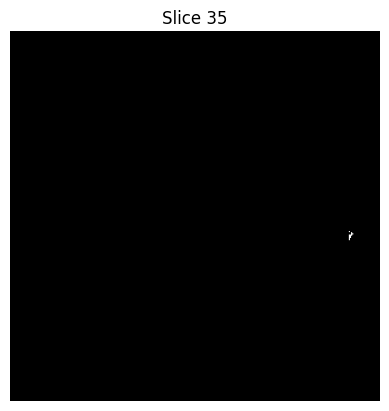

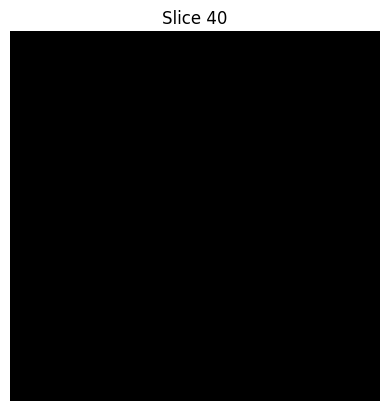

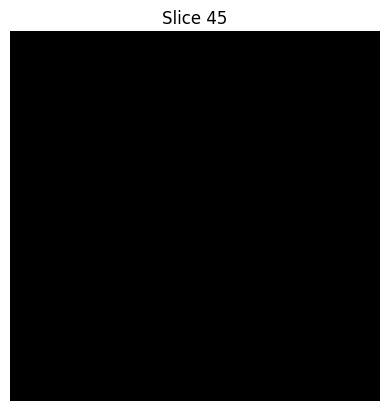

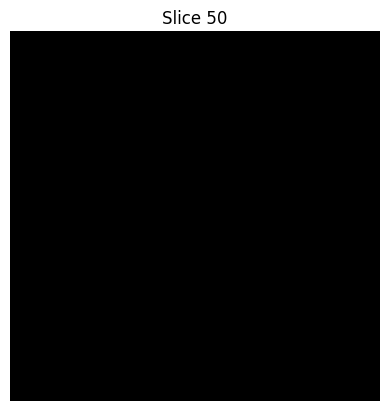

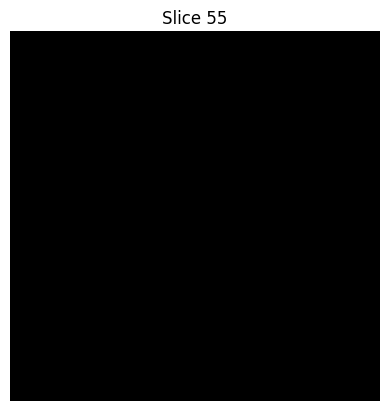

In [21]:
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline

img = nib.load("F:/Rawan_Masterarbeit/TotalsegmentatorMRI_dataset/heart.nii.gz")
data = img.get_fdata()

for i in range(0, data.shape[2], 5):  # Alle 5 Slices anzeigen
    plt.imshow(data[:, :, i], cmap="gray")
    plt.title(f"Slice {i}")
    plt.axis("off")
    plt.show()


In [15]:
import os
import nibabel as nib
import numpy as np
from scipy.ndimage import rotate

# Ordnerpfad mit den resamplten Bildern
input_dir = r"F:\Rawan_Masterarbeit\data\Heart\resampled_images"  # Dein Ordner mit den Bilddateien
output_dir = r"F:\Rawan_Masterarbeit\data\Heart\resampled_rotated_images"  # Zielordner für gedrehte Bilder
os.makedirs(output_dir, exist_ok=True)

# Durchlaufe alle NIfTI-Dateien im Ordner
for filename in os.listdir(input_dir):
    if filename.endswith(".nii.gz"):  # Nur NIfTI-Dateien
        nifti_path = os.path.join(input_dir, filename)
        
        # Lade das NIfTI-Bild
        nii_img = nib.load(nifti_path)
        nii_data = nii_img.get_fdata()
        
        # Leeres Array für das gedrehte Volumen
        rotated_volume = np.zeros_like(nii_data)
        
        # Schleife über alle Slices in z-Richtung und drehe um 90° gegen den Uhrzeigersinn
        for z in range(nii_data.shape[2]):
            slice_2d = nii_data[:, :, z]
            
            # Drehe Slice um 90° gegen den Uhrzeigersinn ohne Änderung der Form
            rotated_slice = rotate(slice_2d, angle=90, reshape=False)
            
            # Speichere das gedrehte Slice zurück
            rotated_volume[:, :, z] = rotated_slice
        
        # Neues NIfTI-Objekt erstellen
        rotated_img = nib.Nifti1Image(rotated_volume, affine=nii_img.affine)
        
        # Speicherpfad anpassen
        rotated_path = os.path.join(output_dir, f"rotated_{filename}")
        nib.save(rotated_img, rotated_path)
        
        print(f"✅ {filename} wurde um 90° gedreht und gespeichert unter: {rotated_path}")


In [2]:
'''
import nibabel as nib
import matplotlib.pyplot as plt

img = nib.load("F:/Rawan_Masterarbeit/data/Heart/resampled_rotated_images/rotated_resampled_la_003.nii.gz")
data = img.get_fdata()

for i in range(0, data.shape[2], 5):  # Alle 5 Slices anzeigen
    plt.imshow(data[:, :, i], cmap="gray")
    plt.title(f"Slice {i}")
    plt.axis("off")
    plt.show()
'''

'\nimport nibabel as nib\nimport matplotlib.pyplot as plt\n\nimg = nib.load("F:/Rawan_Masterarbeit/data/Heart/resampled_rotated_images/rotated_resampled_la_003.nii.gz")\ndata = img.get_fdata()\n\nfor i in range(0, data.shape[2], 5):  # Alle 5 Slices anzeigen\n    plt.imshow(data[:, :, i], cmap="gray")\n    plt.title(f"Slice {i}")\n    plt.axis("off")\n    plt.show()\n'

In [3]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import gc
import logging
from tqdm import tqdm
from totalsegmentator.python_api import totalsegmentator

# Logging konfigurieren
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Ordnerpfade
images_dir = "data/Heart/resampled_images"
visualization_dir = "data/Heart/segmentation_total_segmentator_atrium_left_results_resampled_images"
mask_dir = "data/Heart/segmentation_total_segmentator_atrium_left_results_resampled_images"
os.makedirs(visualization_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

# Zielgröße der Ground-Truth-Bilder
target_size = (1024, 1024)  # (Breite, Höhe)

# Segmentierung + Maske + Visualisierung
def segment_and_save(images_dir, visualization_dir, mask_dir, organ_label="heart"):
    image_files = sorted(os.listdir(images_dir))

    temp_output_base = "data/Heart/temp_segmentations_total_mr_resampled_images"
    os.makedirs(temp_output_base, exist_ok=True)

    for image_file in tqdm(image_files, desc="Processing files"):
        image_path = os.path.join(images_dir, image_file)

        if not (image_file.endswith(".nii") or image_file.endswith(".nii.gz")):
            continue

        # Ordner für diese Datei im temp_output anlegen
        base_name = os.path.splitext(os.path.splitext(image_file)[0])[0]  # z.B. la_018
        temp_output = os.path.join(temp_output_base, base_name)
        if not os.path.exists(temp_output):
            os.makedirs(temp_output)

        try:
            # Segmentierung starten mit speziellem Task
            totalsegmentator(
                input=image_path,
                output=temp_output,
                task="total_mr"
                # roi_subset=[organ_label]
            )
        except Exception as e:
            logging.error(f"Fehler bei der Segmentierung von {image_file}: {e}")
            continue

        # Bilddaten laden
        nii_img = nib.load(image_path)
        image_data = nii_img.get_fdata()

        # Pfad zur Segmentierung im Unterordner
        seg_path = os.path.join(temp_output, f"{organ_label}.nii.gz")
        if not os.path.exists(seg_path):
            logging.warning(f"Keine Segmentierung für {image_file} gefunden.")
            continue

        nii_seg = nib.load(seg_path)
        seg_data = nii_seg.get_fdata()

        total_slices = image_data.shape[2]

        for slice_idx in range(total_slices):
            img_slice = image_data[:, :, slice_idx]
            seg_slice = seg_data[:, :, slice_idx]

            # Binäre Maske
            seg_mask = (seg_slice > 0).astype(np.uint8)

            # Visualisierung
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            ax[0].imshow(img_slice, cmap="gray")
            ax[0].set_title(f"Original Slice {slice_idx}")
            ax[0].axis('off')
            ax[1].imshow(img_slice, cmap="gray")
            ax[1].imshow(seg_mask, cmap="jet", alpha=0.5)
            ax[1].set_title(f"Segmentierung Slice {slice_idx}")
            ax[1].axis('off')

            vis_save_path = os.path.join(visualization_dir, f"{base_name}_slice_{slice_idx}_visualization.png")
            plt.savefig(vis_save_path, bbox_inches="tight")
            plt.close(fig)

            # Maske auf 1024 x 1024 skalieren
            seg_mask_resized = cv2.resize(seg_mask, target_size, interpolation=cv2.INTER_NEAREST)

            # Maske speichern
            mask_save_path = os.path.join(mask_dir, f"{base_name}_slice_{slice_idx}_segmentation.png")
            cv2.imwrite(mask_save_path, seg_mask_resized * 255)

            gc.collect()

        # Optional: Temp Ordner komplett löschen
        # Achtung: Wenn du die Ergebnisse behalten willst, bitte nicht löschen!
        # import shutil
        # shutil.rmtree(temp_output)

# Ausführen
segment_and_save(images_dir, visualization_dir, mask_dir)


2025-06-12 11:03:59,351 - INFO - NumExpr defaulting to 4 threads.
Processing files:   0%|                                                                         | 0/20 [00:00<?, ?it/s]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.18s
Predicting part 1 of 2 ...


F:\Rawan_Masterarbeit\venv_totalseg\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:03<00:00, 15.48s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:49<00:00, 13.70s/it]


  Predicted in 301.56s
Resampling...
Saving segmentations...
  Saved in 42.90s


Processing files:   5%|███                                                           | 1/20 [07:28<2:21:52, 448.01s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.29s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:56<00:00, 14.52s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:55<00:00, 14.40s/it]


  Predicted in 292.93s
Resampling...
Saving segmentations...
  Saved in 46.30s


Processing files:  10%|██████▏                                                       | 2/20 [14:39<2:11:30, 438.35s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.29s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:57<00:00, 14.67s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:57<00:00, 14.74s/it]


  Predicted in 292.86s
Resampling...
Saving segmentations...
  Saved in 52.24s


Processing files:  15%|█████████▎                                                    | 3/20 [21:48<2:02:56, 433.92s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.59s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:08<00:00, 16.08s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:59<00:00, 14.89s/it]


  Predicted in 322.07s
Resampling...
Saving segmentations...
  Saved in 48.48s


Processing files:  20%|████████████▍                                                 | 4/20 [29:32<1:58:54, 445.88s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.30s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:08<00:00, 16.03s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:57<00:00, 14.68s/it]


  Predicted in 327.86s
Resampling...
Saving segmentations...
  Saved in 48.55s


Processing files:  25%|███████████████▌                                              | 5/20 [37:24<1:53:49, 455.29s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.20s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:50<00:00, 13.78s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:01<00:00, 15.20s/it]


  Predicted in 289.88s
Resampling...
Saving segmentations...
  Saved in 40.22s


Processing files:  30%|██████████████████▌                                           | 6/20 [43:58<1:41:23, 434.53s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.52s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:56<00:00, 14.62s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:00<00:00, 15.08s/it]


  Predicted in 283.77s
Resampling...
Saving segmentations...
  Saved in 42.32s


Processing files:  35%|█████████████████████▋                                        | 7/20 [50:42<1:31:57, 424.40s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.56s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:03<00:00, 15.46s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:57<00:00, 14.74s/it]


  Predicted in 289.79s
Resampling...
Saving segmentations...
  Saved in 53.87s


Processing files:  40%|████████████████████████▊                                     | 8/20 [57:47<1:24:55, 424.62s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.58s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:11<00:00, 16.48s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:02<00:00, 15.30s/it]


  Predicted in 324.06s
Resampling...
Saving segmentations...
  Saved in 49.40s


Processing files:  45%|███████████████████████████                                 | 9/20 [1:05:19<1:19:26, 433.36s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.52s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:06<00:00, 15.85s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:05<00:00, 15.65s/it]


  Predicted in 321.71s
Resampling...
Saving segmentations...
  Saved in 50.10s


Processing files:  50%|█████████████████████████████▌                             | 10/20 [1:12:49<1:13:02, 438.24s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.28s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:50<00:00, 13.82s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:48<00:00, 13.55s/it]


  Predicted in 260.78s
Resampling...
Saving segmentations...
  Saved in 46.24s


Processing files:  55%|████████████████████████████████▍                          | 11/20 [1:19:08<1:03:01, 420.15s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.78s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:50<00:00, 13.76s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:47<00:00, 13.48s/it]


  Predicted in 274.59s
Resampling...
Saving segmentations...
  Saved in 42.56s


Processing files:  60%|████████████████████████████████████▌                        | 12/20 [1:25:41<54:54, 411.84s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.56s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:49<00:00, 13.68s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:47<00:00, 13.41s/it]


  Predicted in 259.01s
Resampling...
Saving segmentations...
  Saved in 1475.39s


Processing files:  65%|██████████████████████████████████████▎                    | 13/20 [1:55:51<1:37:28, 835.44s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.31s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:51<00:00, 13.91s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:47<00:00, 13.38s/it]


  Predicted in 291.63s
Resampling...
Saving segmentations...
  Saved in 51.92s


Processing files:  70%|█████████████████████████████████████████▎                 | 14/20 [2:02:56<1:11:09, 711.56s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.13s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:05<00:00, 15.74s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:57<00:00, 14.63s/it]


  Predicted in 305.55s
Resampling...
Saving segmentations...
  Saved in 41.95s


Processing files:  75%|█████████████████████████████████████████████▊               | 15/20 [2:09:52<51:51, 622.39s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.80s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:10<00:00, 16.31s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:14<00:00, 16.76s/it]


  Predicted in 314.77s
Resampling...
Saving segmentations...
  Saved in 48.33s


Processing files:  80%|████████████████████████████████████████████████▊            | 16/20 [2:17:02<37:38, 564.59s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.69s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:16<00:00, 17.03s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:00<00:00, 15.10s/it]


  Predicted in 307.50s
Resampling...
Saving segmentations...
  Saved in 37.18s


Processing files:  85%|███████████████████████████████████████████████████▊         | 17/20 [2:23:58<25:59, 519.73s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.72s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:50<00:00, 13.84s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:47<00:00, 13.49s/it]


  Predicted in 259.74s
Resampling...
Saving segmentations...
  Saved in 40.69s


Processing files:  90%|██████████████████████████████████████████████████████▉      | 18/20 [2:30:12<15:52, 476.00s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.04s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:50<00:00, 13.83s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:50<00:00, 13.77s/it]


  Predicted in 261.60s
Resampling...
Saving segmentations...
  Saved in 40.98s


Processing files:  95%|█████████████████████████████████████████████████████████▉   | 19/20 [2:36:15<07:22, 442.07s/it]

No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.56s
Predicting part 1 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:50<00:00, 13.84s/it]


Predicting part 2 of 2 ...



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:49<00:00, 13.72s/it]


  Predicted in 263.14s
Resampling...
Saving segmentations...
  Saved in 32.65s


Processing files: 100%|█████████████████████████████████████████████████████████████| 20/20 [2:42:20<00:00, 487.01s/it]


In [6]:
# rotieren und zuschnitten

In [ ]:
# pip install ipywidgets
# jupyter nbextension enable --py widgetsnbextension
# jupyter notebook
# pip install --upgrade jupyter
